Dung Nguyen

Advanced Data Analytics - D213 

NLM2 Task 1: Time Series Modeling

January 03, 2022

**Scenario 1: Task 1 Medical Time Series (Readmission)**

In the medical industry, readmission of patients is such a problem that the Centers for Medicare and Medicaid Services (CMS) penalizes hospitals for excessive readmissions. When it comes to readmission penalties, studies show that many hospitals are overconfident and underprepared. The percentage of hospitals penalized for readmissions has increased each year since CMS began imposing penalties, reaching a high of 78% for fiscal year 2015. However, three-quarters of hospitals feel confident in their ability to reduce readmissions, and only 55% of them anticipate receiving a penalty this fiscal year. Given the historical trend the percentage of hospitals penalized will likely be much higher than 55%.
Additionally, although hospitals are applying various reduction strategies, fewer than 1 in 5 use technology that is specific to reducing their readmissions, so they may not be doing all that they can.

As part of the “readmission” project, executives would like to see consider a time series on revenue from the first years of operation. Once they understand any patterns in that data, they feel confident in understanding the impact of readmission in current times. The given time series data records the daily revenue, in million dollars, during the first two years of operation.

**Data File being used:**
medical_time_series.csv

**Data Dictionary:**

The data set consists of 731 rows (days) and two columns or variables:
Day: Day during first two years of operation
Revenue: Revenue in million dollars

# Part 1: Research Question

**A1. Research Question:**

Can we identify meaningful patterns in time series data of the hospital's revenues over two years?

**A2. The goal of the data analysis:**
    
We will identify which meaningful patterns in revenues will give the hospital a better understanding of why the readmission happens. In addition, the business will be able to correlate the readmission rate over time with trends identified in the time series data. Finally, we can extrapolate their relationship to medical readmission from identified patterns.

# Part 2: Method Justification

**B1. Time series model assumptions:**

The first assumption of time series techniques is **stationary**. "Stationary data refers to the time series data that mean, and variance do not vary across time. The data is considered non-stationary if there is a strong trend or seasonality observed from the data." (Wu, 2021) 

If the mean level of a stationary series is constant, essential to time series analysis is handling temporal dependence. It is critical in most cases because the analysis built many models upon the assumption that mean and variance are stable over time. The stationary means that the data distribution is the same or does not change with time. The time series must fulfill three criteria to be stationary. The series has zero trends, and it is not growing or shrinking.

Another assumption of time series is **autocorrelated**. "Autocorrelation is the correlation between two observations at different points in a time series. For example, values separated by an interval might have a strong positive or negative correlation. When these correlations are present, they indicate that past values influence the current value." (Frost, n.d). 

We usually use the ACF - Autocorrelation function to identify which lags have significant corrections and understand the time-series pattern. We can also assess the stationarity, which can determine the decomposed data trend, seasonal, and residual trend.



# Part 3: Data Preparation

**C1. Line graph visualizing**

In [1]:
#1. Install necessary packages
!pip install pandas
!pip install numpy

# Install pmdarima
!pip install pmdarima


In [2]:
# Ignor warning error
import warnings
warnings.filterwarnings('ignore')

# Standard imports
import os
import sys
import pandas as pd
from pandas import Series, DataFrame
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#for encoding
%matplotlib inline 

# Import Scikit-learn 
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt


#Import adfuller class
from statsmodels.tsa.stattools import adfuller

# Active Decomposition the training set
from statsmodels.tsa.seasonal import seasonal_decompose

# Import auto_arima class
from pmdarima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf



In [3]:
#2. Read and check the data set in Python using Pandas' read_csv command
path = 'medical_time_series.csv'
medical_df_clean = pd.read_csv(path)

In [4]:
#3.Display Medical dataframe
medical_df = medical_df_clean.copy()
medical_df.head()

,Day,Revenue
0,1,0.000000
1,2,-0.292356
2,3,-0.327772
3,4,-0.339987
4,5,-0.124888


In [5]:
type(medical_df)

pandas.core.frame.DataFrame

In [6]:
medical_df.head()

,Day,Revenue
0,1,0.000000
1,2,-0.292356
2,3,-0.327772
3,4,-0.339987
4,5,-0.124888


In [7]:
#4. Evaluate the data structure to understand input data better
# Dataset size
medical_df.shape

(731, 2)

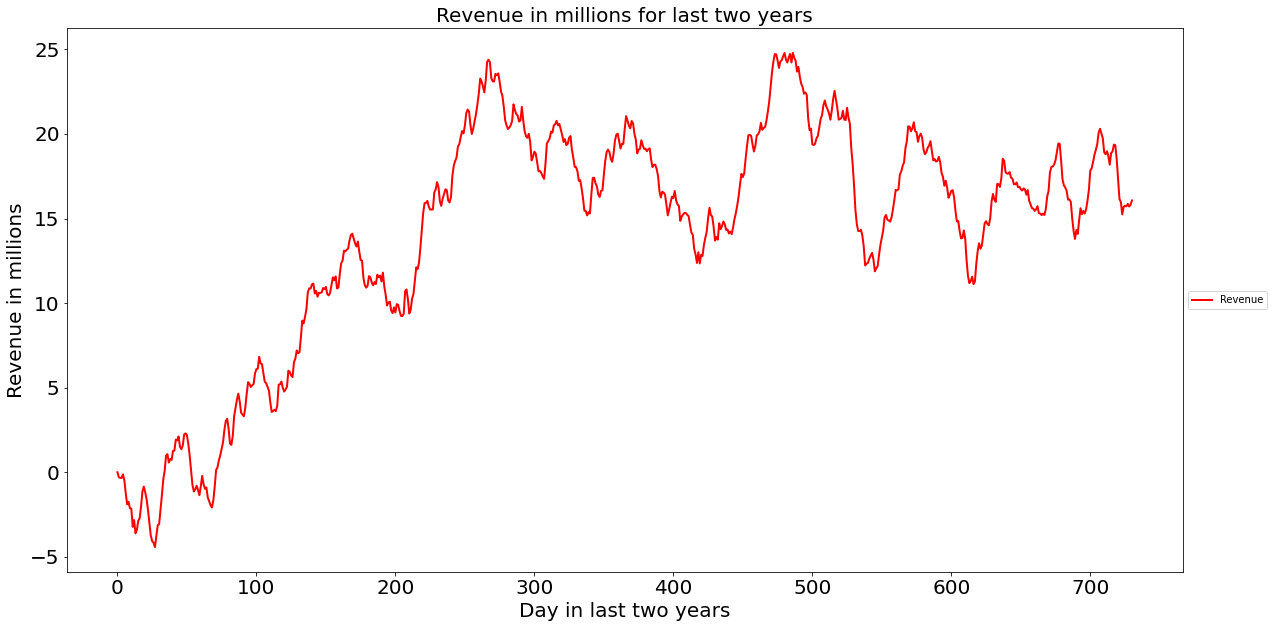

In [8]:
# Line graph visualizing
medical_df[['Revenue']].plot(figsize=(20,10), color = 'red', linewidth=2, fontsize=20)

title_obj = plt.title('Revenue in millions for last two years', fontsize=20 ) #get the title property handler
plt.xlabel('Day in last two years', fontsize=20)
plt.ylabel('Revenue in millions',fontsize=20)

# Color of legend font
legend = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Save plot to directory
plt.savefig('Revenue in millions for last two years.jpg');


In [9]:
# Visualize inital line graph of dataset
#def plot_df(df, x, y, title='', xlabel='Day', ylabel='Revenue', dpi=100):
#    plt.figure(figsize=(15, 4), dpi=dpi)
#    plt.plot(x, y, color='tab:red')
#    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
#   plt.show()
#plot_df(medical_df, x=medical_df['Day'], y=medical_df['Revenue'],
#title='Medical Revenue in millions for last two years')

**C2. Time step formatting of the realization**

In [10]:
# Check the information of data
medical_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Day      731 non-null    int64  
 1   Revenue  731 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 11.5 KB


In [11]:
# Describe Churn dataset statistics
medical_df.describe()

,Day,Revenue
count,731.000000,731.000000
mean,366.000000,14.179608
std,211.165812,6.959905
min,1.000000,-4.423299
25%,183.500000,11.121742
50%,366.000000,15.951830
75%,548.500000,19.293506
max,731.000000,24.792249


In [12]:
#5. Re-validate column, null values, and find missing values.
# check null values
df = medical_df
data_nulls = df.isnull().sum()
print(data_nulls)

Day        0
Revenue    0
dtype: int64


There are no null values.

In [13]:
# check missing data and its size
def missing_cols(medical_df):
    '''prints out columns with its amount of missing values'''
    total = 0
    for col in medical_df.columns:
        missing_vals = medical_df[col].isnull().sum()
        total += missing_vals
        if missing_vals != 0:
            print(f"{col} => {medical_df[col].isnull().sum()}")
    
    if total == 0:
        print("There are no missing values left")
            
missing_cols(medical_df)

There are no missing values left


In [14]:
#6. Display any duplicate rows in the Day column.
print(medical_df.Day.duplicated().sum())

0


There are no duplicated rows in the Day column.

In [15]:
# Revenue range in column
print("Minimum Revenue is", int(medical_df.Revenue.min()))
print("Maximum Revenue is", int(medical_df.Revenue.max()))
print("Revenue range is", int(medical_df.Revenue.max()-medical_df.Revenue.min()))

Minimum Revenue is -4
Maximum Revenue is 24
Revenue range is 29


**C3. Stationarity**

"Stationary data refers to the time series data that mean, and variance do not vary across time. The data is considered non-stationary if there is a strong trend or seasonality observed from the data." (Wu, 2021) . 

If the mean level of a stationary series is constant, essential to time series analysis is handling temporal dependence. It is critical in most cases because the analysis built many models upon the assumption that mean and variance are stable over time. The stationary means that the data distribution is the same or does not change with time. The time series must fulfill three criteria to be stationary. The series has zero trends, and it is not growing or shrinking.

I will use the Dicky Fuller test to evaluate the stationarity of the time series data in this assignment.


In [16]:
#Import adfuller class

#from statsmodels.tsa.stattools import adfuller
#results = adfuller(medical_df['Revenue'])
#print(results)

In [17]:
#Import adfuller class
from statsmodels.tsa.stattools import adfuller

def ad_test(medical_df):
    results = adfuller(medical_df.loc[:, 'Revenue'].values, autolag='AIC')
    print("1.ADF: ", results[0])
    print("2.p-Value: ", results[1])
    print("3.Number of Lags: ", results[2])
    print("4.Numner of Observation: ", results[3])
    print("5.Critical Values: ")
    
    for key, val in results[4].items():
        print("\t", key, ": ", val)

In [18]:
ad_test(medical_df)

1.ADF:  -2.2183190476089476
2.p-Value:  0.19966400615064267
3.Number of Lags:  1
4.Numner of Observation:  729
5.Critical Values: 
	 1% :  -3.4393520240470554
	 5% :  -2.8655128165959236
	 10% :  -2.5688855736949163


The test statistic is -2.2183190476089476, more negative more to be stationarity.
The P-value is 0.19966400615064267. If the p-value is less than 0.05, we will reject the null hypothesis and accept the time series is stationary.

The number of lags used is 1. The number of observations used is 729.

The critical value of test statistic at 1% is -3.4393520240470554. 

The critical value of test statistic at 5% is -2.8655128165959236.

The critical value of test statistic at 10% is -2.5688855736949163.

The critical value of test statistics accociates to different p-values. If we wanted a p-value of 0.01 or below, our test statistic needed to be below -3.4393520240470554. If we wanted a p-value of 0.05 or below, our test statistic needed to be below -2.8655128165959236. If we wanted a p-value of 0.1 or below, our test statistic needed to be below -2.5688855736949163.

With an alpha set (p-value) at 0.05, we can say that our more significant p-value of 0.19966400615064267 demonstrates that the dataset is **non-stationary**.

**C4. Steps for preparation:**

**Step 1: There are step for preparation:**
1.	Install necessary packages
2.	Read and check the data set in Python using Pandas' read_csv command
3.	Naming the dataset as the variable "medical_df" and subsequent proper slices of the data frame as "medical_df".
4.	Evaluate the data structure to understand input data better
    * Line graph visualizing the realization of the time series
5.	Re-validate column, null values, and find missing values.
6.	Display any duplicate rows in the data frame.
    * Evaluate the stationarity of the time series
7.	Split DataFrame into training and test sets
8.	Show the prepared data. (the medical_prepared_data.csv)

**Step 2: Analyse seasonality, trends and residuals by using stats models decomposition**
1.	Active Decomposition the training set
2.	From Active Decomposition the training set above, run seasonality result
3.	From Active Decomposition the training set above, run trend result
4.	From Active Decomposition the training set above, run residuals result
5.	Auto Correlation
6.	Power Spectral density

**Step 3: Autoregressive integrated moving average (ARIMA) model**

Note: In part C3, we identified that the dataset is non-stationary.

1.	Set 'Day' as index column
2.	Difference the data points - Create 'Revenue Diff' column, rename the columns
3.	Naming the dataset as the variable "medical_base" and subsequent proper slices of the data frame as "medical_base".
4.	Drop N/A row
5.	Show the medical_base_data.csv
6.	Order for ARIMA Model, fit auto_arima to dataset
7.	Split data into training and testing
8.	Visualize training and test sets side-by-side
9.	Train the model

**Step 4: Forecast using the derived ARIMA model**
1.  Forecast in different set interval
2.	Predictions with the test set
    * Check the mean, mean squared error,  root mean squared error
3.	Prediction with the complete data set
4.	Prediction for next 1 year (365 days) - future value

**Step 5: Results**


**Code for Step 1, 2, 3, 4, 5, 6 - Please see above**

In [19]:
#7. Split DataFrame into training and test sets

In [20]:
# Train set - Split the DataFrame in 2 years (0:365 - 366:731)
medical_df['Day'] = medical_df.index

medical_train = medical_df.iloc[:len(medical_df) - 365]

medical_train['medical_train'] = medical_train['Revenue']
del medical_train['Day']
del medical_train['Revenue']

In [21]:
# Test set
medical_test = medical_df.iloc[len(medical_df) - 365:]

medical_test['medical_test'] = medical_test['Revenue']
del medical_test['Day']
del medical_test['Revenue']

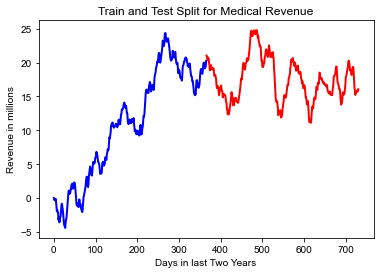

In [22]:
# Visualize training and test sets
plt.plot(medical_train, color='blue', linewidth=2)
plt.plot(medical_test, color='red', linewidth=2)
plt.title('Train and Test Split for Medical Revenue')
plt.xlabel('Days in last Two Years')
plt.ylabel('Revenue in millions')
sns.set()

# Save plot to directory
plt.savefig('Train and Test Split for Medical Revenue.jpg');

plt.show()

**C5. Prepared dataset**

In [23]:
# Prepared data set copy: medical_prepared_time_series.csv
for col in medical_df.columns:
    print('-' * 40 + col + '-' * 40 , end=' - ')
    display(medical_df[col].value_counts())

medical_df.to_csv("medical_prepared_time_series.csv", index=False)

----------------------------------------Day---------------------------------------- - 

0      1
480    1
482    1
483    1
484    1
      ..
245    1
246    1
247    1
248    1
730    1
Name: Day, Length: 731, dtype: int64

----------------------------------------Revenue---------------------------------------- - 

0.000000     1
2.567445     1
23.685281    1
14.885428    1
22.765373    1
            ..
17.345789    1
20.430897    1
18.931722    1
20.956170    1
19.398979    1
Name: Revenue, Length: 731, dtype: int64

# Part 4:  Analysis

**D1. Report findings with visualizations:**

**Decomponsition**

We will analyze seasonality, trends, and residuals by using statsmodels decomposition.

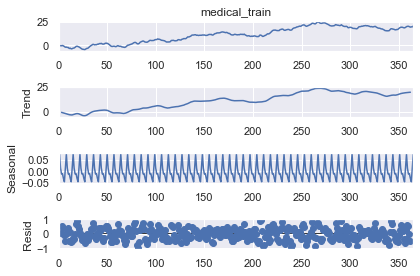

In [24]:
# Active Decomposition the training set
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(medical_train['medical_train'], model='additive', period=7)
result.plot()

# Save plot to directory
plt.savefig('Active Decomposition Medical Train.jpg');

**Seasonal component**

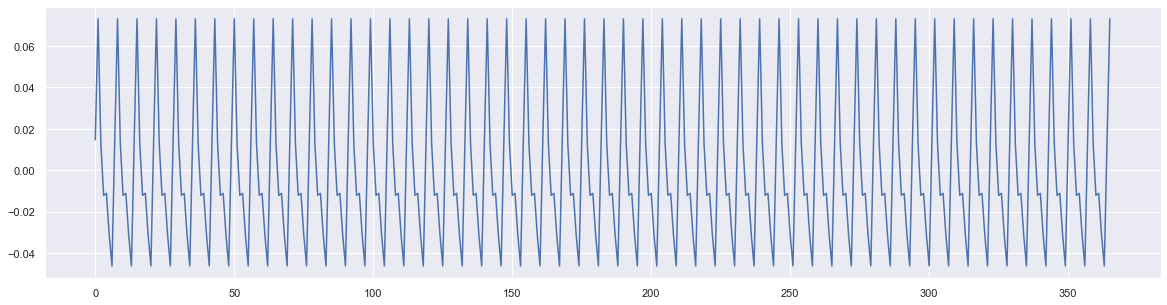

In [25]:
#From Active Decomposition the training set above, run seasonality result
plt.figure(figsize=(20, 5), linewidth=2)
plt.plot(result.seasonal)

The seasonality in the time series are cycles that repeat over time. "A repeating pattern within each year is known as seasonal variation, although the term is applied more generally to repeating patterns within any fixed period." (Metcalfe Andrew, page 6, 2009). 
Based on the decomposition and the seasonal component chart, we can see seasonality. 

**Trends**

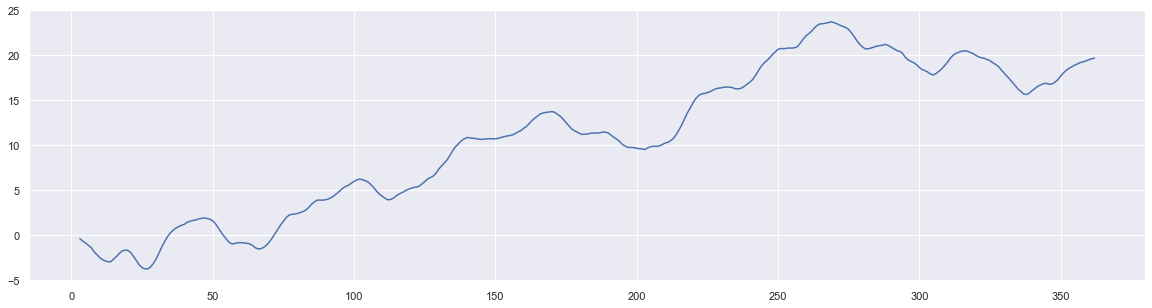

In [26]:
#From Active Decomposition the training set above, run trend result
plt.figure(figsize=(20, 5), linewidth=2)
plt.plot(result.trend)

The trend is a pattern that shows the movement of a time series to higher or lower values over time. It means a trend is observed and shows a decreasing or increasing slope in the time series. 

According to Greek for Geeks, it could be:

* Uptrend: Time Series Analysis shows a general upward pattern called  Uptrend.
* Downtrend: Time Series Analysis shows a downward pattern, then it is Downtrend.
* Horizontal or Stationary trend: If no pattern is observed, it is called a Horizontal or stationary trend.

(Greek for Geeks, n.d)

Our trend - general direction for the medical hospital over two years is increasing revenue or an upward trend. 


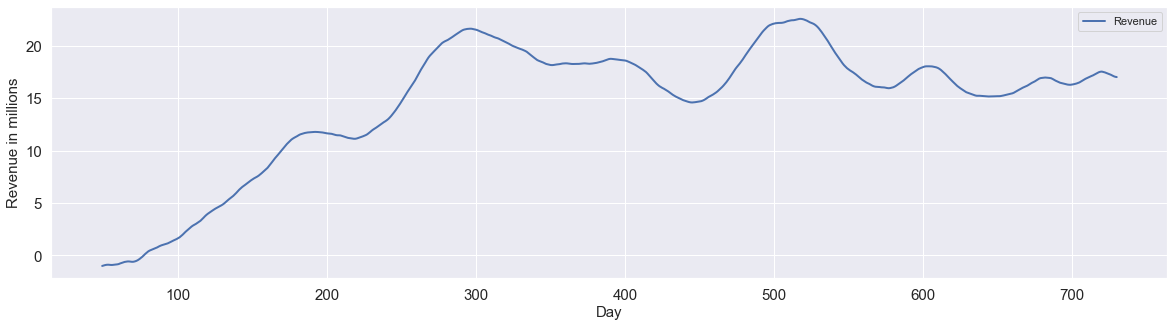

In [27]:
#Sample - Virtualize the trend in time series - rolling 50 days
revenue = medical_df[['Revenue']]
revenue.rolling(50).mean().plot(figsize=(20,5), linewidth=2, fontsize=15)
plt.xlabel('Day', fontsize=15)
plt.ylabel('Revenue in millions', fontsize=15);

**Residuals**

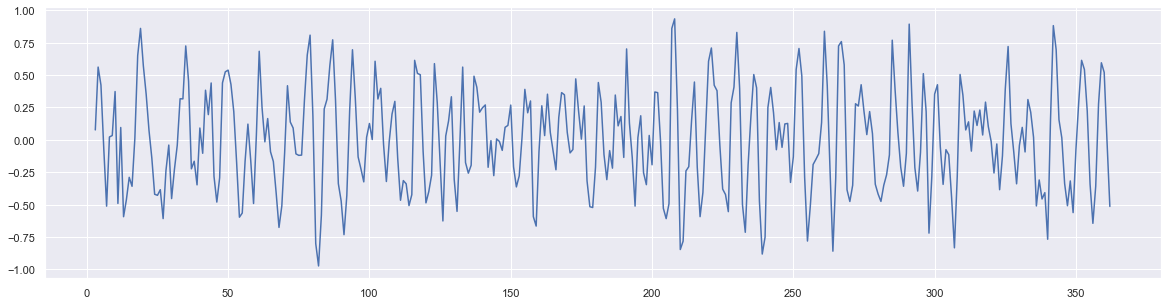

In [28]:
#From Active Decomposition the training set above, run residuals result
plt.figure(figsize=(20, 5), linewidth=2)
plt.plot(result.resid)

Residuals are 'errors' which are the differences between expected and predicted values in the dataset. Like trends and seasonality, the residuals can have a temporal structure. However, we can see no 'trend' in residuals from the decomposition and residual result above. 

The residuals show periods of high variability in the early and later years of the series. The trend and seasonality visualized above also seem reasonable. 

**Auto Correlation**

"Autocorrelation is the correlation between two observations at different points in a time series. Values that are separated by an interval might have a strong positive or negative correlation." (Frost, n.d)

In this assignment, I will use ACF - the autocorrelation function to access the random and stationary of the time series. Then, I can identify which lags have significant correlations, understand the time series pattern, fit that in the appropriate models, and make forecasts. 

A partial autocorrelation function (PACF) is the same as ACF except for each correlation controls for any correlation between observations of a shorter lag length.

In [29]:
#Compute the correlation coefficients of all of these time series
medical_df.corr()

,Day,Revenue
Day,1.000000,0.662738
Revenue,0.662738,1.000000


In [30]:
#compute the correlation coefficients of the first-order differences of these time series
#medical_df.diff().corr()

In [31]:
# Compute the autocorrelation coefficient of the time series with lag = 31 days (1 month)

medical_autocorr_lag1 = medical_df['Revenue'].autocorr(lag=31)
print("One Month (31 days) Lag: ", medical_autocorr_lag1)

One Month (31 days) Lag:  0.811957636173828


In [32]:
# Compute the autocorrelation coefficient of the time series with lag = 93 days (3 month)

medical_autocorr_lag3 = medical_df['Revenue'].autocorr(lag=93)
print("Three Month (93 days) Lag: ", medical_autocorr_lag3)

Three Month (93 days) Lag:  0.6130153846104823


In [33]:
# Compute the autocorrelation coefficient of the time series with lag = 182 days (6 month)

medical_autocorr_lag6 = medical_df['Revenue'].autocorr(lag=182)
print("Six Month (182 days) Lag: ", medical_autocorr_lag6)

Six Month (182 days) Lag:  0.1322882156706793


In [34]:
# Compute the autocorrelation coefficient of the time series with lag = 365 days (1 year)

medical_autocorr_lag1y = medical_df['Revenue'].autocorr(lag=365)
print("One Year (365 days) Lag: ", medical_autocorr_lag1y)

One Year (365 days) Lag:  -0.19922114869202553


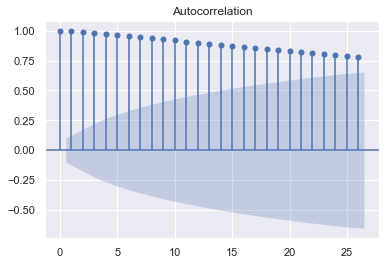

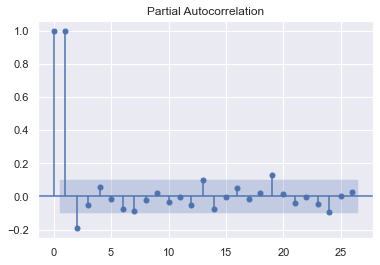

In [35]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf
# Use the Autocorrelation function from the statsmodel library passing

#Plot autocorrelation with training set
plot_acf(medical_train)
plot_pacf(medical_train)
# Show the AR as a plot
plt.show()

**Spectral density**

The spectral density analysis allows us to discover and understand the underlying periodicities.

(array([1.52612936e+04, 8.12118786e+03, 2.62760550e+02, 1.24454986e+02,
        5.40026379e+01, 2.55196420e+01, 2.89237553e+01, 6.29449800e+00,
        8.38967529e+00, 8.79735213e+00, 3.26244345e+00, 5.16464998e+00,
        4.64370619e+00, 1.96867736e+00, 1.48167320e+00, 2.11256649e+00,
        1.08550271e+00, 5.81988645e-01, 2.76744723e+00, 2.22308983e+00,
        5.50876230e-01, 7.49752606e-01, 1.26157210e+00, 8.77859381e-01,
        4.84404330e-01, 4.39565525e-01, 2.05055025e-01, 9.50457901e-01,
        5.23499207e-01, 4.35456489e-01, 1.69884060e+00, 8.97977002e-01,
        7.28275718e-01, 6.11527179e-01, 1.49053313e+00, 5.44383887e-01,
        2.17350902e-01, 5.07814496e-01, 4.43820257e-01, 2.94184611e-01,
        2.55373626e-01, 9.44702588e-02, 1.58619217e-01, 1.88829134e-01,
        2.11804293e-01, 6.04121179e-01, 4.95073852e-01, 2.15698285e-01,
        1.04432711e-01, 1.46393379e-01, 2.07457981e-01, 1.26602668e-01,
        1.74592665e-01, 1.42674366e-01, 9.63196690e-02, 1.177682

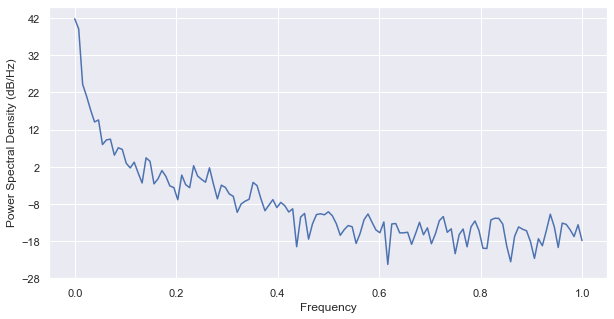

In [36]:
# Power Spectral density
plt.figure(figsize=(10,5), linewidth=3)
plt.psd(medical_df['Revenue'])


**D2. Autoregressive integrated moving average (ARIMA) model**

The ARIMA model stands for autoregressive integrated moving average model, a class of statistical models for analyzing and forecasting the time series data. According to Brownlee, the keys are:


1. "AR: Autoregression, a model that uses the dependent relationship between an observation and some number of lagged observations.

2. I: Integrated, differencing raw observations (e.g., subtracting an observation from observation at the previous time step) to make the time series stationary.

3. MA: Moving Average, a model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations."

(Brownlee, 2017)

In part C3, we evaluated the stationarity of the time series. We used the Dicky-Fuller test that our data was non-stationary. Therefore, we need to differentiate the data to convert it to a stationary model to forecast future values.


In [37]:
#Check dataframe type
type(medical_df)

pandas.core.frame.DataFrame

In [38]:
#set Day as index column
medical_df = pd.read_csv('medical_time_series.csv', index_col=[0],parse_dates=True, squeeze=True)

In [39]:
#Check dataframe type
type(medical_df)

pandas.core.series.Series

In [40]:
#Difference the data points - Create diff revenue column for forecasting
#medical_base = pd.concat([medical_df, medical_df['Revenue'].shift(1)], axis=1)

medical_base = pd.concat([medical_df, medical_df.shift(1)], axis=1)

In [41]:
medical_base

,Revenue,Revenue
Day,,
1,0.000000,NaN
2,-0.292356,0.000000
3,-0.327772,-0.292356
4,-0.339987,-0.327772
5,-0.124888,-0.339987
...,...,...
727,15.722056,15.754749
728,15.865822,15.722056
729,15.708988,15.865822


In [42]:
#Rename the columns
medical_base.columns = ['Actual_Revenues', 'Forecast_Revenues']

In [43]:
medical_base.head()

,Actual_Revenues,Forecast_Revenues
Day,,
1,0.000000,NaN
2,-0.292356,0.000000
3,-0.327772,-0.292356
4,-0.339987,-0.327772
5,-0.124888,-0.339987


In [44]:
#drop N/A row 
medical_base.dropna(inplace=True)

In [45]:
medical_base.head()

,Actual_Revenues,Forecast_Revenues
Day,,
2,-0.292356,0.000000
3,-0.327772,-0.292356
4,-0.339987,-0.327772
5,-0.124888,-0.339987
6,-0.491590,-0.124888


In [46]:
# Data set copy: medical_base_time_series.csv
for col in medical_base.columns:
    print('-' * 40 + col + '-' * 40 , end=' - ')
    display(medical_base[col].value_counts())

medical_base.to_csv("medical_base_time_series.csv", index=False)

----------------------------------------Actual_Revenues---------------------------------------- - 

19.080317    1
2.567445     1
23.685281    1
14.885428    1
22.765373    1
            ..
20.430897    1
18.931722    1
20.956170    1
5.043155     1
19.398979    1
Name: Actual_Revenues, Length: 730, dtype: int64

----------------------------------------Forecast_Revenues---------------------------------------- - 

0.000000     1
2.567445     1
23.685281    1
14.885428    1
22.765373    1
            ..
20.430897    1
18.931722    1
20.956170    1
5.043155     1
19.398979    1
Name: Forecast_Revenues, Length: 730, dtype: int64

In [47]:
#Ignore harmless warinings
import warnings
warnings.filterwarnings("ignore")

In [48]:
#Order for ARIMA Model, fit auto_arima to dataset
from pmdarima import auto_arima

arima_fit = auto_arima(medical_base['Forecast_Revenues'], trace = True, suppresss_warnings=True)
arima_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=882.866, Time=0.72 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1015.370, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=880.980, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=905.827, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1014.833, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=882.917, Time=0.21 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=882.932, Time=0.28 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=882.968, Time=0.63 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=879.577, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=881.502, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=881.519, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=904.765, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=881.541, Time=0.42 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 3.234 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  730
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -437.789
Date:                Sun, 16 Jan 2022   AIC                            879.577
Time:                        17:10:37   BIC                            888.760
Sample:                             0   HQIC                           883.120
                                - 730                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4141      0.034     12.240      0.000       0.348       0.480
sigma2         0.1945      0.011     17.818      0.000       0.173       0.216
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 1.95
Prob(Q):                              0.90   Prob(JB):                         0.38
Heteroskedasticity (H):               1.00   Skew:                            -0.02
Prob(H) (two-sided):                  1.00   Kurtosis:                         2.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**The results of the report suggest:**

Best model:  ARIMA(1,1,0)

p = AR = 1, the order of the autoregressive, which gives us the predictors's number of lags to be used.

d = I = 1, the integrated term, which is the minimum number of differencing used to make the data stationary

q = MA = 0, the order of the moving average, which give us the number of lagged forecast errors to be used

In [49]:
#Split data into training and testing

#Train set
#print(medical_base.shape)
#ar_train = medical_base.iloc[:len(medical_base) - 365]
#ar_train['ar_train'] = ar_train['Forecast_Revenues']

#Test set
#ar_test= medical_base.iloc[len(medical_base) - 365:]
#ar_test['ar_train'] = ar_test['Forecast_Revenues']

#print(ar_train.shape, ar_test.shape)

In [50]:
#Split data into training and testing

#Train set
print(medical_base.shape)
ar_train = medical_base.iloc[:len(medical_base) - 365]


#Test set
ar_test= medical_base.iloc[len(medical_base) - 365:]

print(ar_train.shape, ar_test.shape)

(730, 2)
(365, 2) (365, 2)


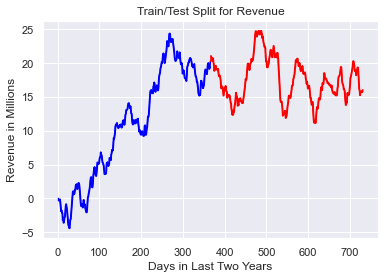

In [51]:
# Visualize training and test sets side-by-side
plt.plot(ar_train, color='blue')
plt.plot(ar_test, color='red')
plt.title('Train/Test Split for Revenue')
plt.xlabel('Days in Last Two Years')
plt.ylabel('Revenue in Millions')
sns.set()
plt.show()

**ARIMA model**

In [52]:
#ARIMA model
from statsmodels.tsa.arima_model import ARIMA

#Train the model
from statsmodels.tools.sm_exceptions import ValueWarning

model = ARIMA(ar_train['Forecast_Revenues'], order = (1,1,0))
model = model.fit()
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARIMA Model Results                              
===============================================================================
Dep. Variable:     D.Forecast_Revenues   No. Observations:                  364
Model:                  ARIMA(1, 1, 0)   Log Likelihood                -218.201
Method:                        css-mle   S.D. of innovations              0.441
Date:                 Sun, 16 Jan 2022   AIC                            442.403
Time:                         17:10:37   BIC                            454.094
Sample:                              1   HQIC                           447.050
                                                                               
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         0.0526      0.039      1.357      0.175      -0.023       0.129
ar.L1.D.Forecast_Revenues     0.4050      0.048      8.464      0.000       0.311       0.499
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.4691           +0.0000j            2.4691            0.0000
-----------------------------------------------------------------------------
"""

**D3. Forecast using the derived ARIMA model**

In [53]:
#Confidence intervals (CI) for model parameters (auto arima) - not prediction
#print(model.conf_int())

In [54]:
#1. Forecast
print(model.forecast())

(array([19.44105498]), array([0.44055057]), array([[18.57759173, 20.30451823]]))


The forecast function in ARIMA returns three arrays: 

The predicted value for the prediction  is 19.44105498

The standard error for the prediction is 0.44055057

Confidence interval (Ci) for the prediction: The default confidence level is 95%. It means a 95% chance of the population will fall between 18.57759173 and 20.30451823. The lower interval is 18.57759173, and the upper interval is 20.30451823.


In [55]:
#Forecast in different set interval:

print('80% Confidence Interval: ',model.forecast(alpha = 0.20))
print('90% Confidence Interval: ', model.forecast(alpha = 0.10))
print('95% Confidence Interval: ',model.forecast(alpha = 0.05))
print('99% Confidence Interval: ',model.forecast(alpha = 0.01))

80% Confidence Interval:  (array([19.44105498]), array([0.44055057]), array([[18.87646671, 20.00564325]]))
90% Confidence Interval:  (array([19.44105498]), array([0.44055057]), array([[18.71641378, 20.16569618]]))
95% Confidence Interval:  (array([19.44105498]), array([0.44055057]), array([[18.57759173, 20.30451823]]))
99% Confidence Interval:  (array([19.44105498]), array([0.44055057]), array([[18.30627192, 20.57583805]]))


Confidence interval (Ci) for the prediction: The confidence level is 80%. It means an 80% chance of the population will fall between 18.87646671 and 20.00564325. The lower interval is 18.87646671, and the upper interval is 20.00564325.

Confidence interval (Ci) for the prediction: The confidence level is 90%. It means a 90% chance of the population will fall between 18.71641378 and 20.16569618. The lower interval is 18.71641378, and the upper interval is 20.16569618.

Confidence interval (Ci) for the prediction: The confidence level is 95%. It means a 95% chance of the population will fall between 18.57759173 and 20.30451823. The lower interval is 18.57759173, and the upper interval is 20.30451823.

Confidence interval (Ci) for the prediction: The confidence level is 99%. It means a 99% chance of the population will fall between 18.30627192 and 20.57583805. The lower interval is 18.30627192, and the upper interval is 20.57583805.


In [56]:
#2. Predictions with the test set

start = len(ar_train)
end = len(ar_train) + len(ar_test)-1
pred = model.predict(start = start, end=end, typ='levels')

print(pred)

364    19.441055
365    19.484343
366    19.533158
367    19.584212
368    19.636172
         ...    
724    38.353211
725    38.405788
726    38.458365
727    38.510942
728    38.563519
Length: 365, dtype: float64


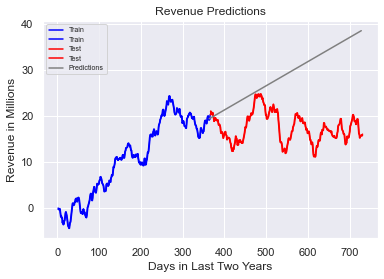

In [57]:
# Visualize the Test set forecast
plt.plot(ar_train, color='blue', label = 'Train')
plt.plot(ar_test, color='red', label = 'Test')
plt.plot(pred, color='gray', label = 'Predictions')
plt.title('Revenue Predictions')
plt.xlabel('Days in Last Two Years')
plt.ylabel('Revenue in Millions')
plt.legend(loc='upper left', fontsize = 7)
sns.set()

# Save plot to directory
plt.savefig('Revenue Predictions.jpg');

plt.show()

In [58]:
#Plot the prediction and the test set with it
#pred.plot(legend=True)
#ar_test['Forecast_Revenues'].plot(legend=True)

From virtualization, we can see this is not a good model. It does not follow the trend of the data set. Now let check the mean square error and root mean squared error of the test and prediction data set.

In [59]:
#Check the mean
ar_test['Forecast_Revenues'].mean()

17.485583451999993

In [60]:
from sklearn.metrics import mean_squared_error
from math import sqrt

#Root mean squared error
rmse = sqrt(mean_squared_error(ar_test['Forecast_Revenues'],pred))
print('RMSE:',rmse)

RMSE: 13.359266444562607


In [61]:
#Mean squared error
mse = mean_squared_error(ar_test['Forecast_Revenues'],pred)
print('MSE:',mse)

MSE: 178.46999993681644


In [62]:
#3. Prediction with the complete data set

model2 = ARIMA(medical_base['Forecast_Revenues'], order = (1,1,0))
model2 = model2.fit()

#Print last 5 values
medical_base.tail()

,Actual_Revenues,Forecast_Revenues
Day,,
727,15.722056,15.754749
728,15.865822,15.722056
729,15.708988,15.865822
730,15.822867,15.708988
731,16.069429,15.822867


729     15.882506
730     15.919748
731     15.947742
732     15.971919
733     15.994519
          ...    
1090    23.667668
1091    23.689159
1092    23.710651
1093    23.732142
1094    23.753633
Name: ARIMA Predictions, Length: 366, dtype: float64


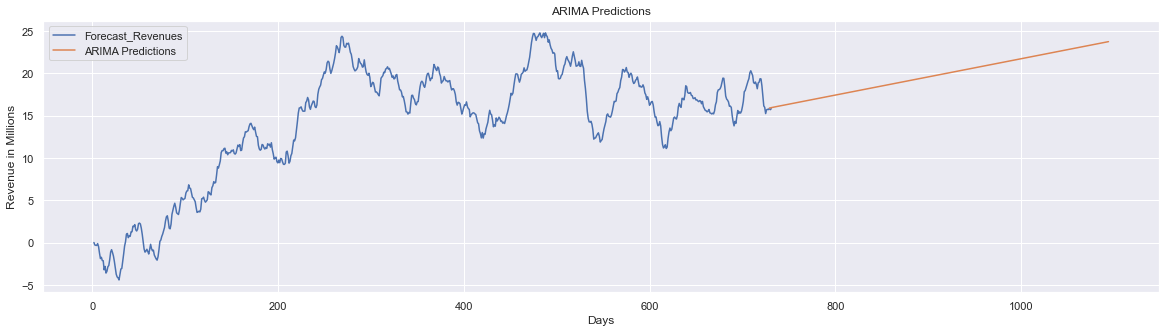

In [63]:
#4. Prediction for next 1 year (365 days) - future value

arima_pred = model2.predict(start=len(medical_base), end=len(medical_base) + 365, typ = 'levels').rename('ARIMA Predictions')
print(arima_pred)

# Visualize predicted values
medical_base['Forecast_Revenues'].plot(figsize = (20, 5), legend = True)
arima_pred.plot(legend = True)

plt.title('ARIMA Predictions')
plt.xlabel('Days')
plt.ylabel('Revenue in Millions')
# Save plot to directory
plt.savefig('ARIMA Predictions.jpg');


**D4. Output and calculations of the analysis**

Please see above.

**D5. code used to support the implementation of the time series model**

Please see above.

# Part 5:  Summary and Implications

**E1. Summary results**
**1. The best ARIMA model to select:** 

Based on the auto_arima, we generated the optimal p, d, and q values, and we selected the ARIMA model with (1,1,0). 

p = AR = 1, the autoregressive order gives us the predictor's number of lags to be used.

d = I = 1, the integrated term, the minimum number of differencing used to make the data stationary.

q = MA = 0, the order of the moving average, which gives us the number of lagged forecast errors to be used.

The Akaike Information Criterion (AIC) resulted in a value of 442.403, which was lower than  879.577.

The Schwartz Bayesian Information Criterion (BIC) resulted in a value of 454.094, which was lower than 888.760.


**2. Prediction interval of the forecast:**

The forecast function in ARIMA returns three arrays: 

* The predicted value for the prediction  is 19.44105498

* The standard error for the prediction is 0.44055057

* Confidence interval (Ci) for the prediction: The default confidence level is 95%. It means a 95% chance of the population will fall between 18.57759173 and 20.30451823. The lower interval is 18.57759173, and the upper interval is 20.30451823.

The four tested confidence intervals on the dataset which resulted in:

* Confidence interval (Ci) for the prediction: The confidence level is 80%. It means an 80% chance of the population will fall between 18.87646671 and 20.00564325. The lower interval is 18.87646671, and the upper interval is 20.00564325.
The predicted value for the prediction is 19.44105498, between 18.87646671 and 20.00564325.

* Confidence interval (Ci) for the prediction: The confidence level is 90%. It means a 90% chance of the population will fall between 18.71641378 and 20.16569618. The lower interval is 18.71641378, and the upper interval is 20.16569618.
The predicted value for the prediction is 19.44105498, between 18.71641378 and 20.16569618.

* Confidence interval (Ci) for the prediction: The confidence level is 95%. It means a 95% chance of the population will fall between 18.57759173 and 20.30451823. The lower interval is 18.57759173, and the upper interval is 20.30451823.
The predicted value for the prediction is 19.44105498, between 18.57759173 and 20.30451823.

* Confidence interval (Ci) for the prediction: The confidence level is 99%. It means a 99% chance of the population will fall between 18.30627192 and 20.57583805. The lower interval is 18.30627192, and the upper interval is 20.57583805.
The predicted value for the prediction is 19.44105498, between 18.30627192 and 20.57583805.


**3. Justification of the forecast length:**

This assignment predicts one year (365 days) of revenue to give the business short-term actionable forecasts. From the ARIMA Predictions visualization, we can see it falls short when analyzed concerning the previous two-years continuous upward trend. However, the business will need more data and more analysis to enhance the ability to provide a better understanding of what the following year's profits will look like.

**4. Model evaluation procedure and error metric:**

Mean : 17.485583451999993

RMSE: 13.359266444562607

MSE: 178.46999993681644

The metrics for evaluating this ARIMA model were the mean, the mean squared error, and the root means squared error. These resulted in very high values. MSE is 178.46999993681644; the lower the value, the better, and 0 in value mean the model is perfect. For example, the RMSE value is 13.359266444562607, which is close to the mean value of 17.485583451999993; lower values of RMSE indicate a better fit. I can say that we don't have high confidence in accuracy.

**E2. Visualization of the forecast of the final model and test set**

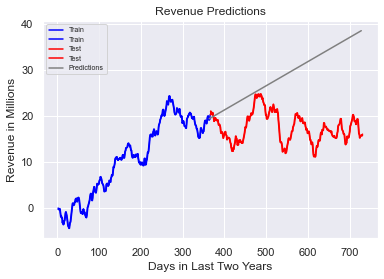

In [64]:
# Visualize the Test set forecast
plt.plot(ar_train, color='blue', label = 'Train')
plt.plot(ar_test, color='red', label = 'Test')
plt.plot(pred, color='gray', label = 'Predictions')
plt.title('Revenue Predictions')
plt.xlabel('Days in Last Two Years')
plt.ylabel('Revenue in Millions')
plt.legend(loc='upper left', fontsize = 7)
sns.set()
plt.show()


729     15.882506
730     15.919748
731     15.947742
732     15.971919
733     15.994519
          ...    
1090    23.667668
1091    23.689159
1092    23.710651
1093    23.732142
1094    23.753633
Name: ARIMA Predictions, Length: 366, dtype: float64


Text(0, 0.5, 'Revenue in Millions')

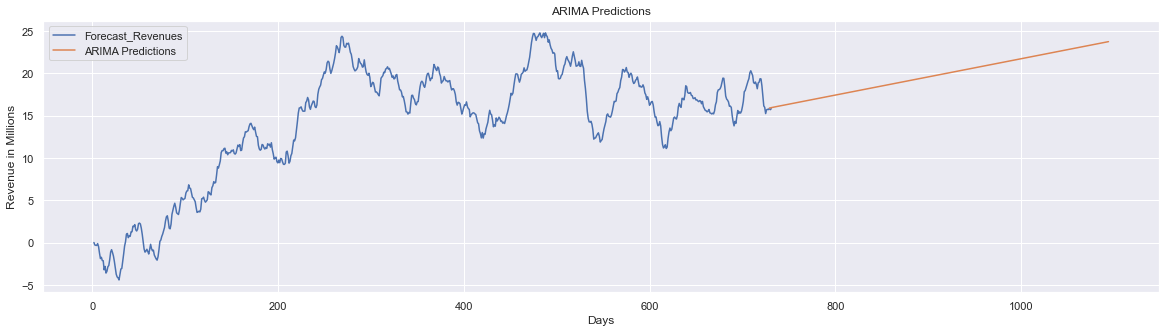

In [65]:
#Final Model - Prediction for next 1 year (365 days) - future value

arima_pred = model2.predict(start=len(medical_base), end=len(medical_base) + 365, typ = 'levels').rename('ARIMA Predictions')
print(arima_pred)

# Visualize predicted values
medical_base['Forecast_Revenues'].plot(figsize = (20, 5), legend = True)
arima_pred.plot(legend = True)

plt.title('ARIMA Predictions')
plt.xlabel('Days')
plt.ylabel('Revenue in Millions')

**E3. Course Action**






Our research question is "Can we identify meaningful patterns in time series data of the hospital's revenues over two years?". The answer is yes, we identified the patterns in the time-series data of the hospital's revenue over two years, and we understand our patients better from a revenue standpoint. Prefer to the earlier report and analysis, the hospital readmission rate was 36.69%. Therefore, it is reasonable to say that the revenue will stay on a similar upward trend with slight, periodic ups and downs regardless of the readmission. 

Based on the results, the business needs to understand that the time series analysis suggests periodicity and an extension of past performance. The early descriptive statistical studies indicate the hospital to analyze the features in common among those leaving the company & attempt to reduce their likelihood of occurring with any given patients in the future. In addition, the hospital should improve more than one service that decreases/increases the patients at high risk of readmission such as Initial_days, Additional_charges, Hyperlipidemia, Services..., not just simple ones. 

I also think we do not have enough data and need to collect more data in a month, year; then, we can look back to the two-year time series dataset, so it may clarify us further.

For more information about readmission rate, please look at the executive dashboard: https://public.tableau.com/app/profile/dung.nguyen5472/viz/MedicalDataLab/Dashboard1?publish=yes


# Part 6: Reporting

**F. Reporting**

Include in submission:

1. Python Jupyter notebook (ipynb)
2. PDF file- Python Jupyter notebook (pdf)
3. Python Jupyter notebook presentation slides (slides)

**G. Sources for third-party code**


[1] Browne-Anderson Hugo. (2018, January 17)).Time Series Analysis Tutorial with Python. https://www.datacamp.com/community/tutorials/time-series-analysis-tutorial

[2] Brownlee Jason. (2017, January 30). How to Decompose Time Series Data into Trend and Seasonality. https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/


[3] Hebbar Nachiketa. (2020, September 05). ARIMA Model In Python-Time Series Forecasting #6. https://www.youtube.com/watch?v=8FCDpFhd1zk


**H. Acknowledge source**

[4] Engineering Statistics Handbook. (n.d). Stationarity. https://www.itl.nist.gov/div898/handbook/pmc/section4/pmc442.htm

[5] Metcalfe Andrew. (2009, n.d). Page 6. Introductory Time Series with R. 

[6] DataCamp. (n.d). Classifying a time series. https://campus.datacamp.com/courses/machine-learning-for-time-series-data-in-python/time-series-as-inputs-to-a-model?ex=1

[7] Songhao Wu. (2021, July 04). Stationarity Assumption in Time Series Data. https://towardsdatascience.com/stationarity-assumption-in-time-series-data-67ec93d0f2f

[8] Geeks for Geeks. (n.d). What is a trend in time series?. https://www.geeksforgeeks.org/what-is-a-trend-in-time-series/

[9] Frost Jim. (n.d). Autocorrelation and Partial Autocorrelation in Time Series Data. https://statisticsbyjim.com/time-series/autocorrelation-partial-autocorrelation/
